In [ ]:
from collections import deque
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
class Interpolator(BaseEstimator, TransformerMixin):
    def __init__(self, freq: str):
        self.freq = freq
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Check if the passed Dataframe has the corrct format
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Expecting a pandas DataFrame")
        if not isinstance(X.index, pd.DatetimeIndex):
            raise ValueError("DataFrame index should be a DatetimeIndex")
        
        # Calculate Timestamps for the given Frequency
        start_date = X.index.min().floor(self.freq)
        end_date = X.index.max()
        all_hours = pd.date_range(start=start_date, end=end_date, freq=self.freq)
        
        # Combine the given Data with the generated Timestamps
        hourly_df = pd.DataFrame(index=all_hours)
        combined_df = pd.concat([X, hourly_df], axis=0).sort_index()
        combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
        
        # Interpolate the Data
        combined_df = combined_df.interpolate(method='linear', limit_direction='both')
        
        # Keep only generated Timestamps
        interpolated_df = combined_df[combined_df.index.floor('30min') == combined_df.index]
        
        return interpolated_df

In [3]:
class RollingMeanFilter(BaseEstimator, TransformerMixin):
    def __init__(self, window_size: int):
        self.window_size = window_size
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.rolling(window=self.window_size, center=True, min_periods=1, win_type='gaussian').mean(std=1)

In [4]:
class ColumnShifter(BaseEstimator, TransformerMixin):
    def __init__(self, shift: int):
        self.shift = shift
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        
        for column in X.columns:
            shifted_column_name = f'{column}_shift_{self.shift}'
            X[shifted_column_name] = X[column].shift(self.shift)
            
        return X[:self.shift]

In [5]:
class IncompleteDayDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.start_date = None
        self.end_date = None
    
    def fit(self, X, y=None):
        self.start_date = X.index.min()
        self.end_date = X.index.max()
        
        return self
        
    def transform(self, X):
        X_filtered = X.copy()

        if not (self.start_date.hour == 0 and self.start_date.minute == 0):
            X_filtered = X_filtered[X_filtered.index.date != self.start_date.date()]
        
        if not (self.end_date.hour == 23 and self.end_date.minute == 30):
            X_filtered = X_filtered[X_filtered.index.date != self.end_date.date()]
        
        return X_filtered

In [6]:
db_user = 'postgres'
db_password = 'password'
db_host = 'localhost'
db_port = '5432'
db_name = 'gas_station'

connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

engine = create_engine(connection_string)

In [179]:
tables = ['omv', 'stark', 'avia']
dataframes = []

for table in tables:
    query = 'SELECT date, e5 FROM omv ORDER BY date'
    
    df = pd.read_sql(query, engine)
    df['e5'] /= 1000
    df.set_index('date', inplace=True)
    dataframes.append(df)
    
len(dataframes)

3

In [185]:
train_sets = []
test_sets = []

for df in dataframes:
    train, test, _, _ = train_test_split(df, df, shuffle=False, test_size=0.15)#
    train_sets.append(train)
    test_sets.append(test)

In [208]:
pipe = Pipeline([
    ('interpolate', Interpolator(freq='30min')),
    ('rolling_mean', RollingMeanFilter(window_size=3)),
    ('drop_incomplete_day', IncompleteDayDropper()),
    ('column_shifter', ColumnShifter(shift=-336))
])
pipe

Pipeline(steps=[('interpolate', Interpolator(freq='30min')),
                ('rolling_mean', RollingMeanFilter(window_size=3)),
                ('drop_incomplete_day', IncompleteDayDropper()),
                ('column_shifter', ColumnShifter(shift=-336))])

In [210]:
X_train_sets = []
y_train_sets = []
X_test_sets = []
y_test_sets = []
for idx, train in enumerate(train_sets):
    preprocessed_train_df = pipe.fit_transform(train)
    X_train = preprocessed_train_df.drop(columns=['e5_shift_-336'])
    y_train = preprocessed_train_df['e5_shift_-336']
    X_train_sets.append(X_train)
    y_train_sets.append(y_train)
    
    preprocessed_test_df = pipe.fit_transform(test_sets[idx])
    X_test = preprocessed_test_df.drop(columns=['e5_shift_-336'])
    y_test = preprocessed_test_df['e5_shift_-336']
    X_test_sets.append(X_test)
    y_test_sets.append(y_test)

In [211]:
def split_data(X: pd.DataFrame, y: pd.Series):
    X_result = []
    y_result = []
    X_day = []
    y_day = []
    
    temp_date = X.index.min().date()
    for date, row in X.iterrows():
        if temp_date != date.date():
            X_result.append(X_day)
            y_result.append(y_day)
            temp_date = date.date()
            X_day = []
            y_day = []
        
        X_day.append(row.e5)
        y_day.append(y.loc[date])
        
    X_result.append(X_day)
    y_result.append(y_day)
        
    return np.array(X_result), np.array(y_result)

In [212]:
X_train_splitted_sets = []
y_train_splitted_sets = []
for idx, X_train in enumerate(X_train_sets):
    X_train_splitted, y_train_splitted = split_data(X_train, y_train_sets[idx])
    X_train_splitted_sets.append(X_train_splitted)
    y_train_splitted_sets.append(y_train_splitted)
    
X_train_splitted = np.vstack(X_train_splitted_sets)
y_train_splitted = np.vstack(y_train_splitted_sets)

X_train_splitted.shape, y_train_splitted.shape

((1452, 48), (1452, 48))

In [213]:
X_test_splitted_sets = []
y_test_splitted_sets = []
for idx, X_test in enumerate(X_test_sets):
    X_test_splitted, y_test_splitted = split_data(X_test, y_test_sets[idx])
    X_test_splitted_sets.append(X_test_splitted)
    y_test_splitted_sets.append(y_test_splitted)
    
X_test_splitted = np.vstack(X_test_splitted_sets)
y_test_splitted = np.vstack(y_test_splitted_sets)

X_test_splitted.shape, y_test_splitted.shape

((126, 48), (126, 48))

In [214]:
model = Sequential([
    Input(shape=(X_train_splitted.shape[1],)),
    Dense(48, activation='relu'),
    # Dropout(rate=0.2),
    Dense(128, activation='relu'),
    # Dropout(rate=0.2),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    # Dropout(rate=0.2),
    Dense(48)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 48)             │         6,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,528 (572.38 KB)

 Trainable params: 146,528 (572.38 KB)

 Non-trainable params: 0 (0.00 B)

In [222]:
X_train_reshaped = X_train_splitted[..., np.newaxis]
X_train_reshaped.shape

(1452, 48, 1)

In [225]:
model = Sequential([
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Conv1D(32, kernel_size=5, activation='relu'),
    Conv1D(32, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(48)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 44, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 40, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 48)             │         3,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,688 (705.81 KB)

 Trainable params: 180,688 (705.81 KB)

 Non-trainable params: 0 (0.00 B)

In [226]:
early_stopping = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)
history = model.fit(X_train_splitted, y_train_splitted, epochs=300, batch_size=16, verbose=True, validation_data=(X_test_splitted, y_test_splitted), callbacks=[early_stopping])

Epoch 1/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2993 - mae: 0.8415 - val_loss: 0.0033 - val_mae: 0.0468
Epoch 2/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017 - mae: 0.0320 - val_loss: 0.0029 - val_mae: 0.0446
Epoch 3/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - mae: 0.0369 - val_loss: 0.0026 - val_mae: 0.0416
Epoch 4/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024 - mae: 0.0390 - val_loss: 0.0017 - val_mae: 0.0315
Epoch 5/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - mae: 0.0328 - val_loss: 0.0016 - val_mae: 0.0309
Epoch 6/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021 - mae: 0.0359 - val_loss: 0.0016 - val_mae: 0.0310
Epoch 7/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mae: 0.0335 - val_loss: 0.0020 - val_mae: 0.0346
Epoch 8/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - mae: 0.0340 - val_loss: 0.0016 - val_mae: 0.0310
Epoch 9/300
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.002

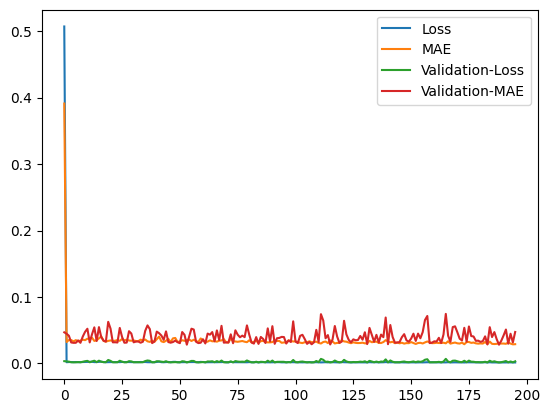

In [227]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_loss'], label='Validation-Loss')
plt.plot(history.history['val_mae'], label='Validation-MAE')

plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


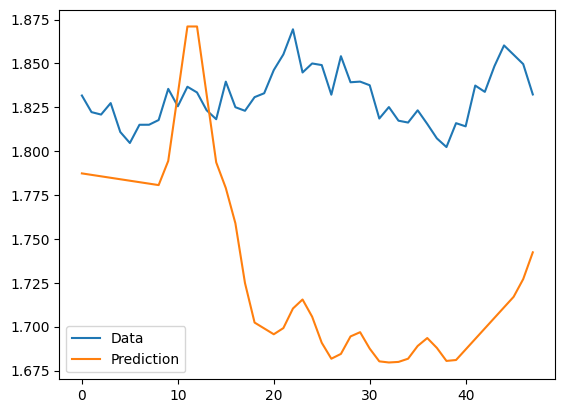

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


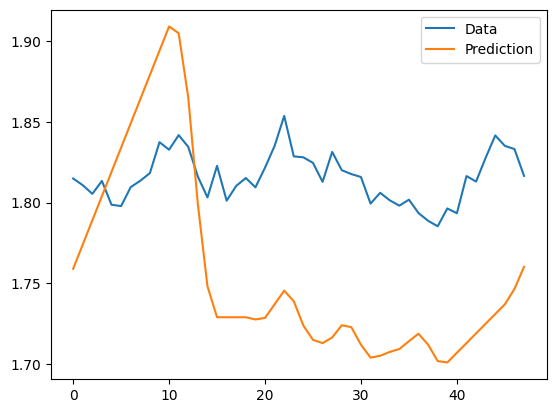

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


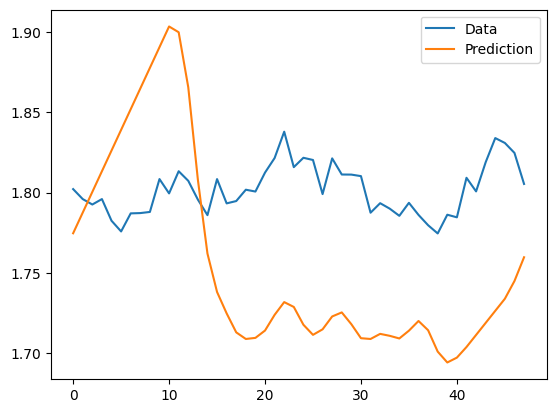

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


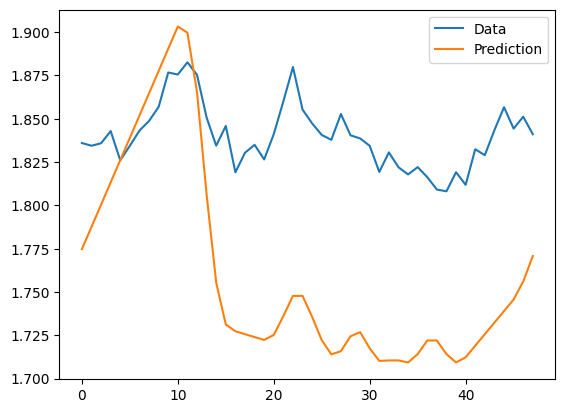

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


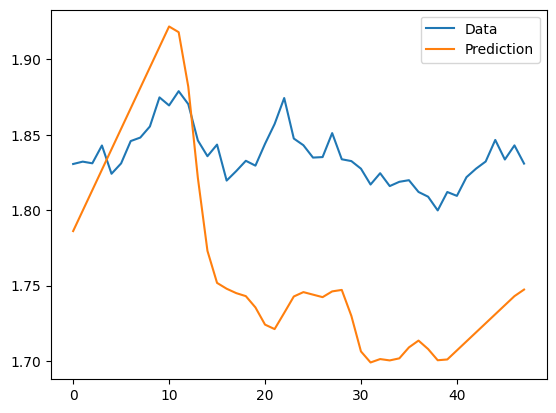

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


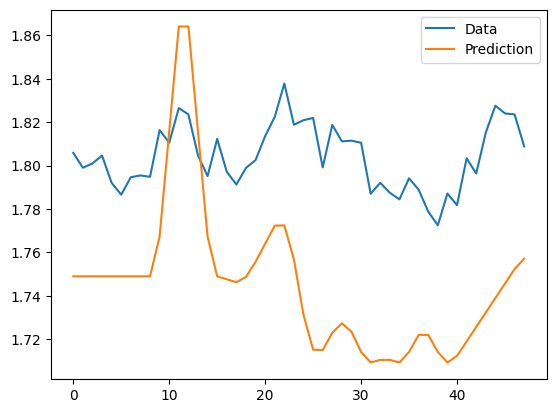

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


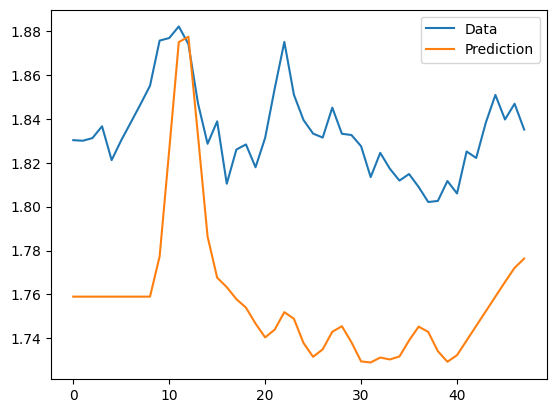

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


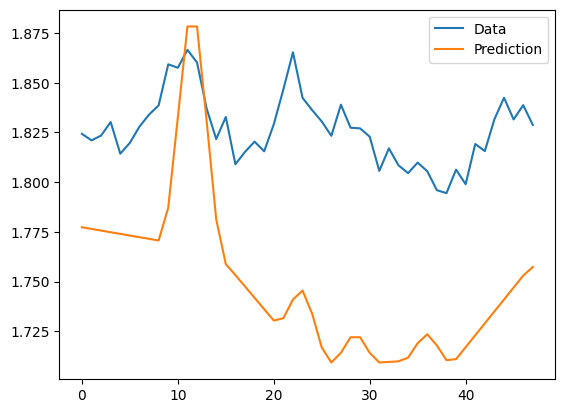

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


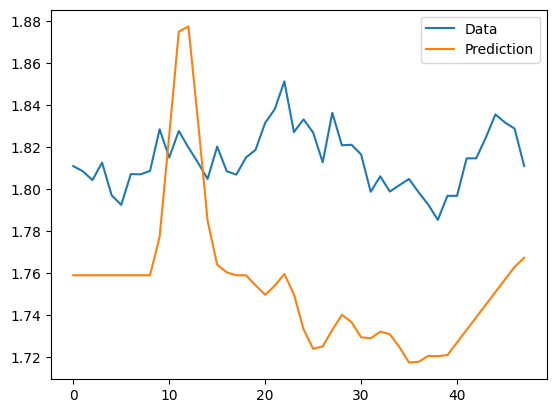

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


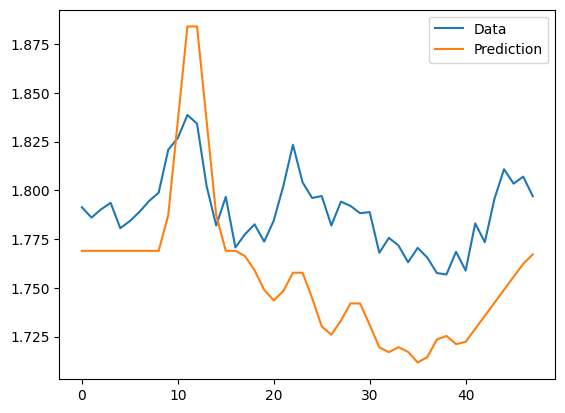

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


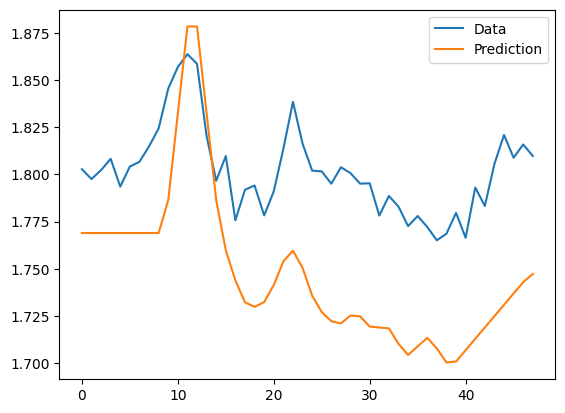

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


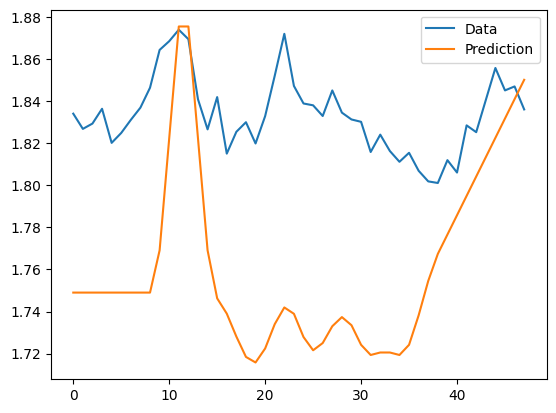

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


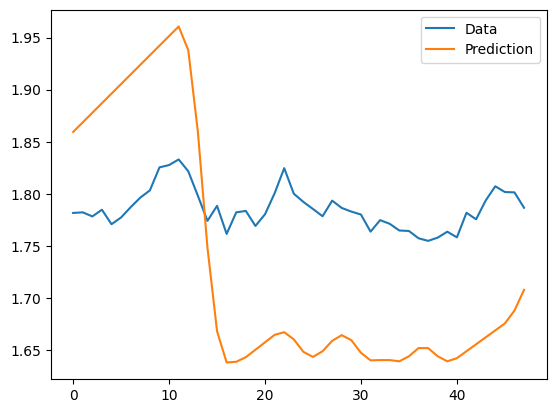

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


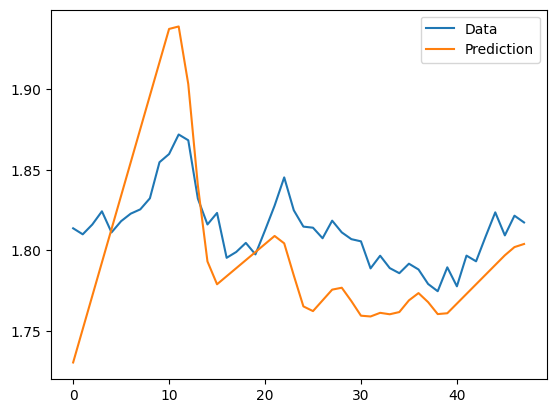

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


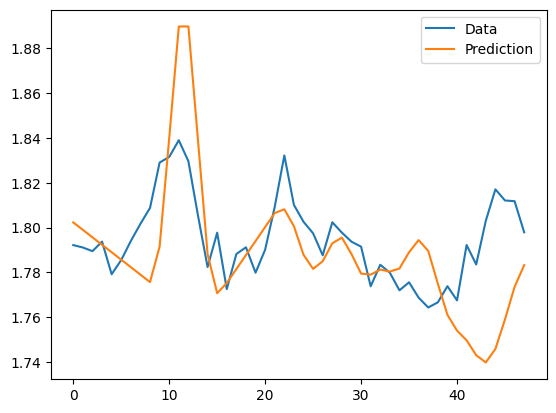

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


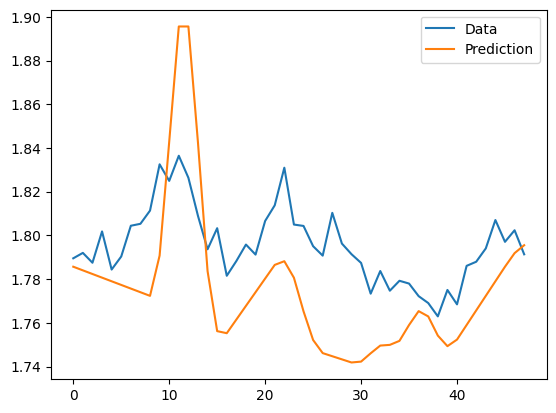

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


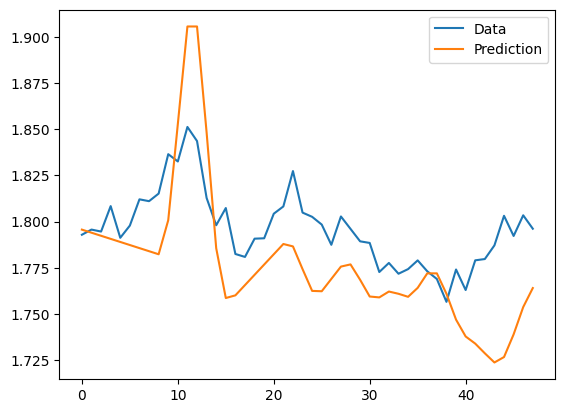

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


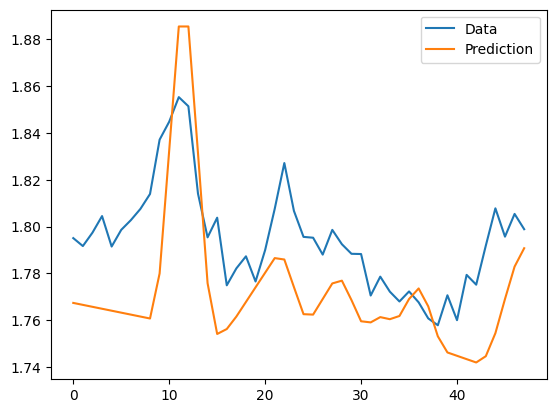

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


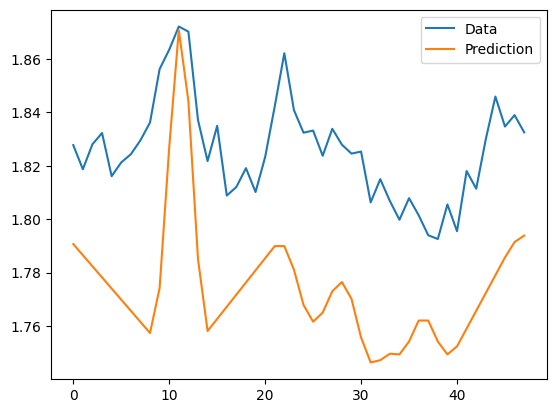

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


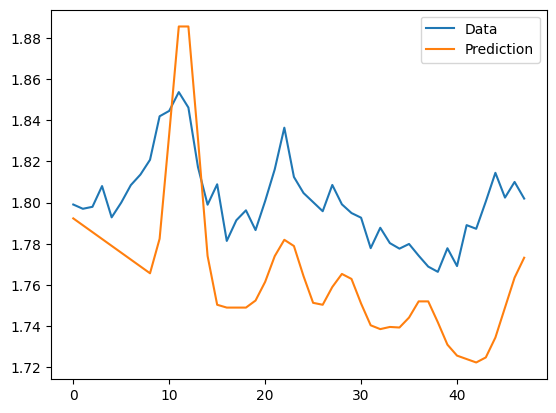

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


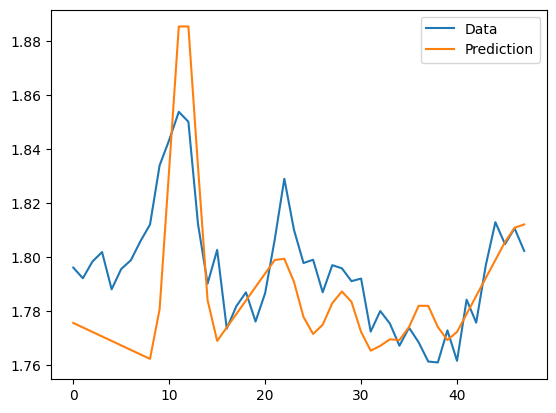

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


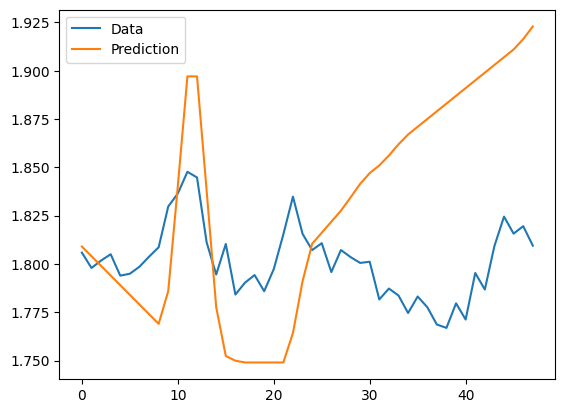

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


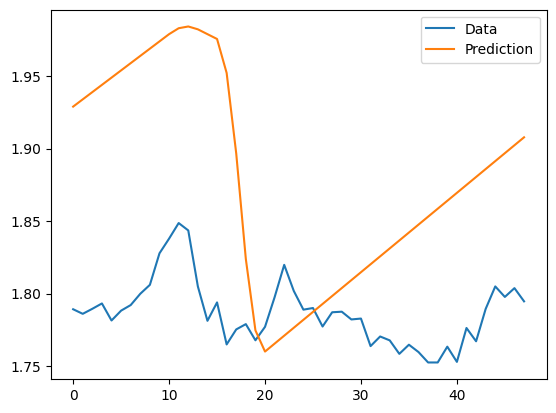

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


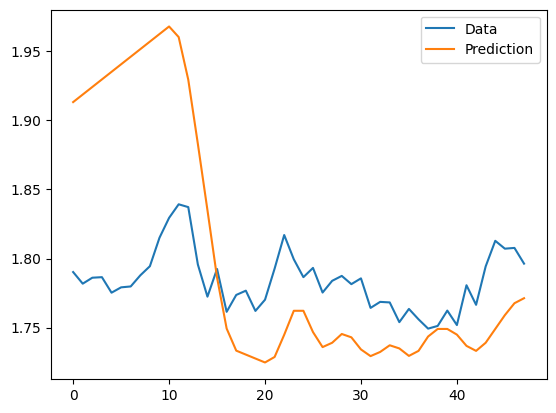

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


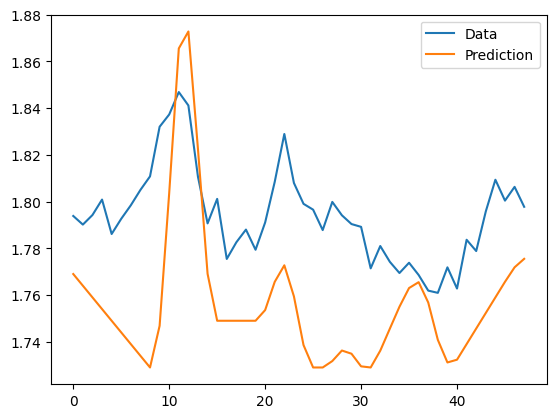

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


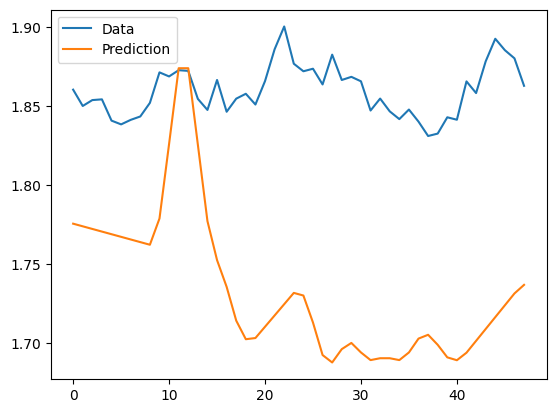

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


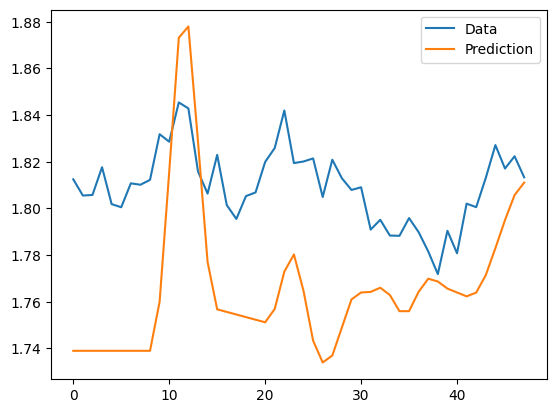

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


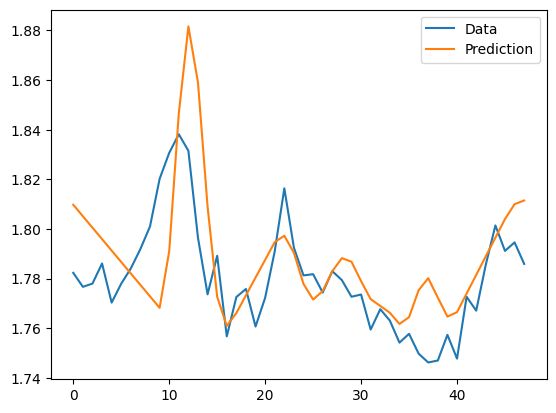

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


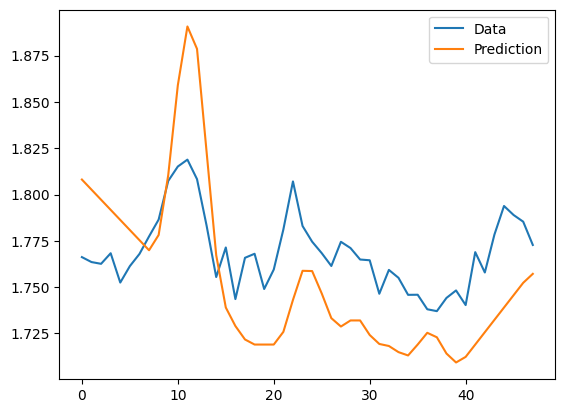

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


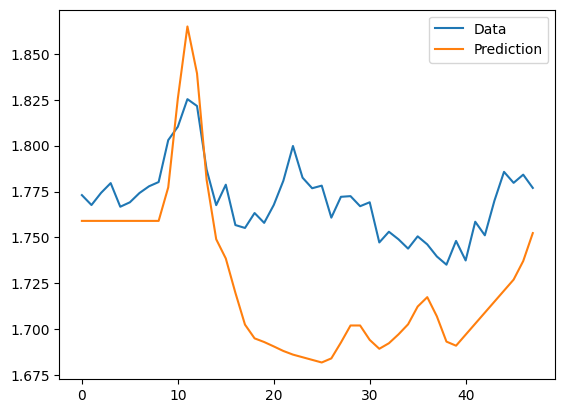

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


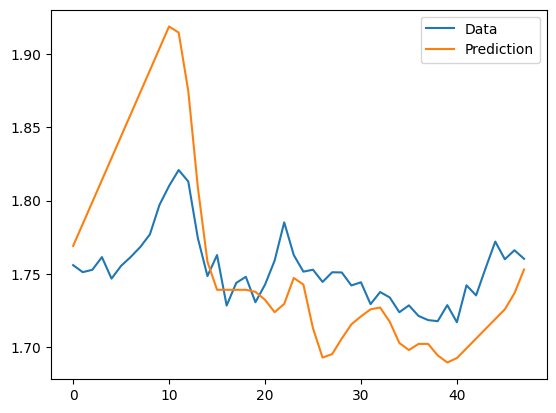

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


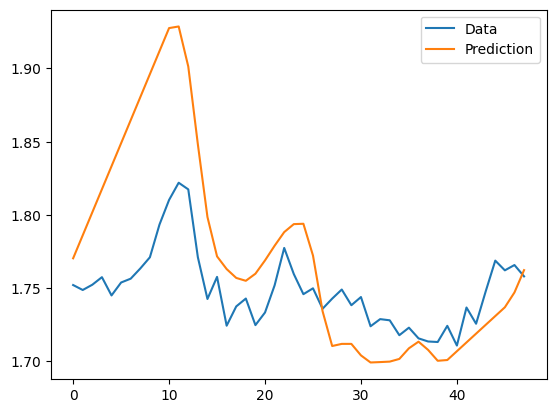

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


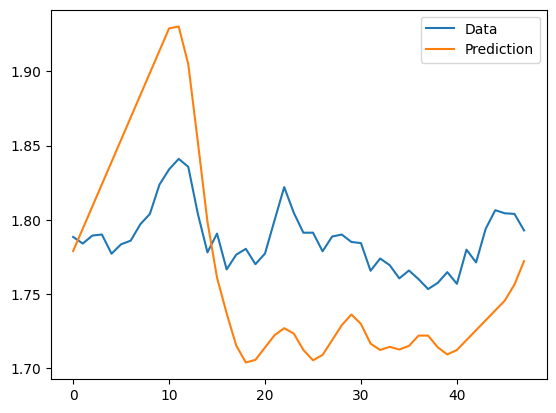

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


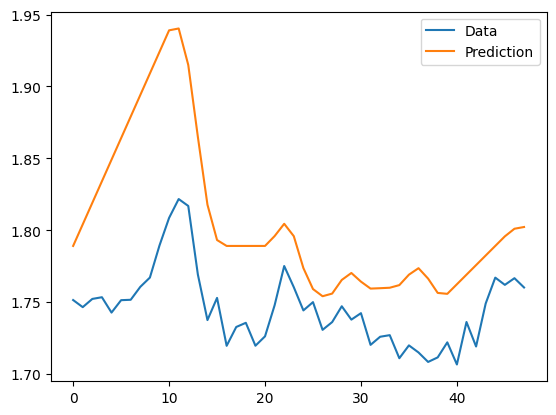

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


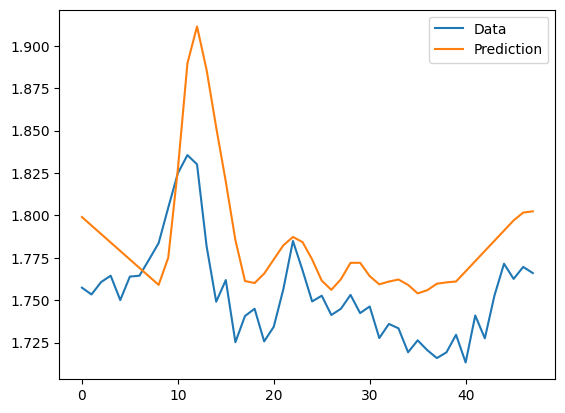

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


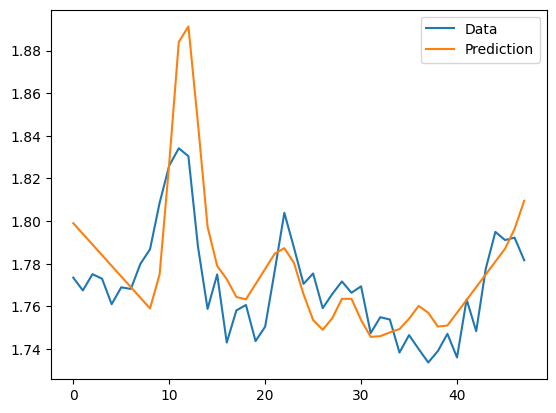

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


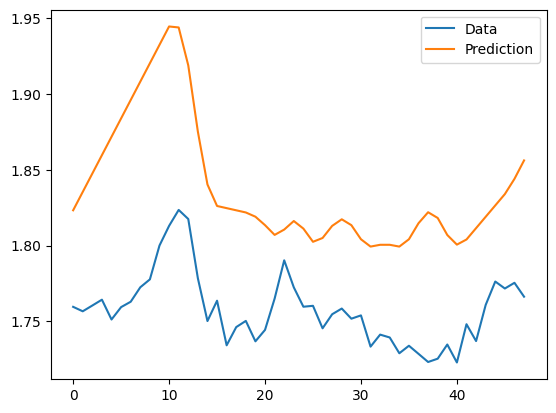

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


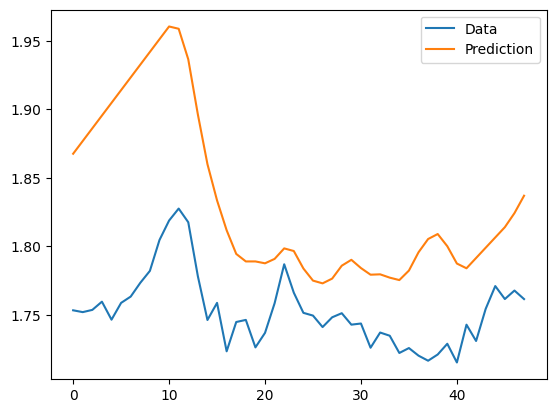

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


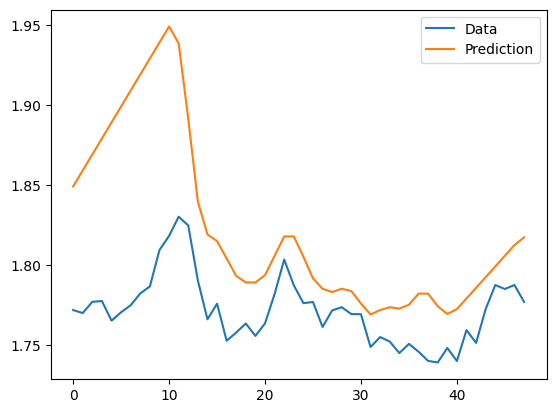

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


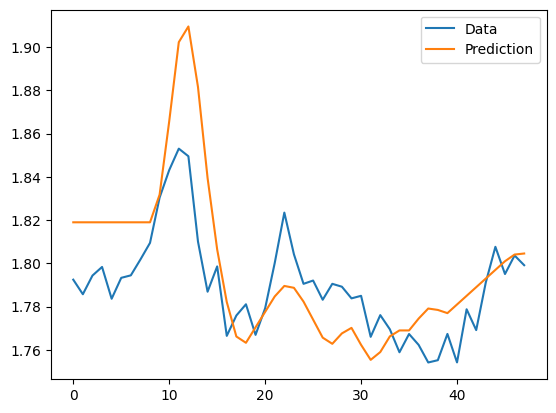

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


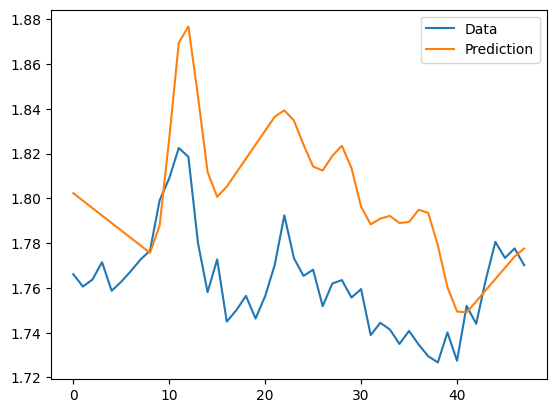

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


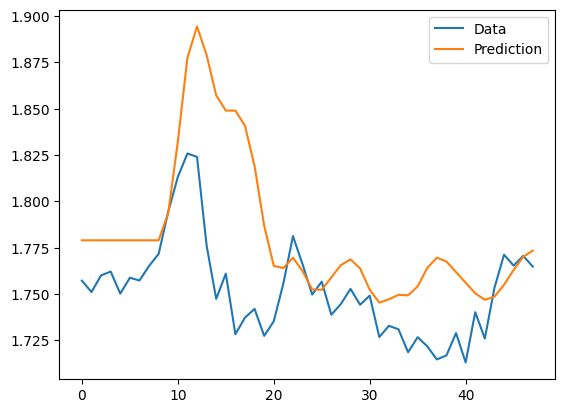

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


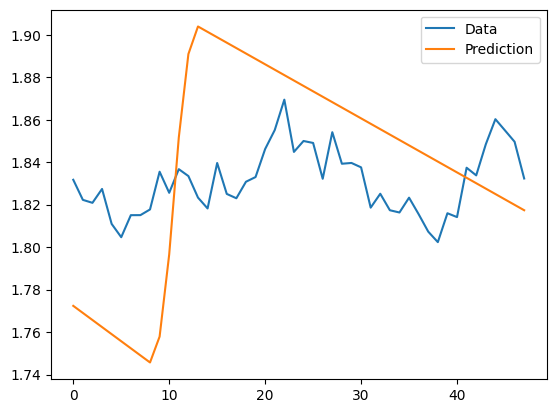

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


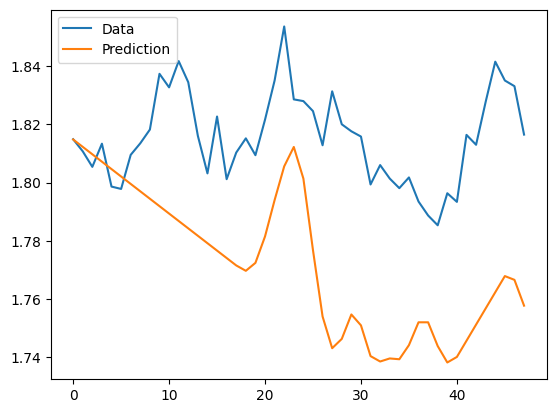

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


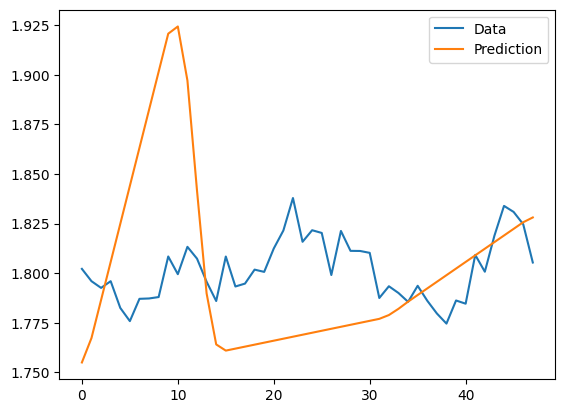

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


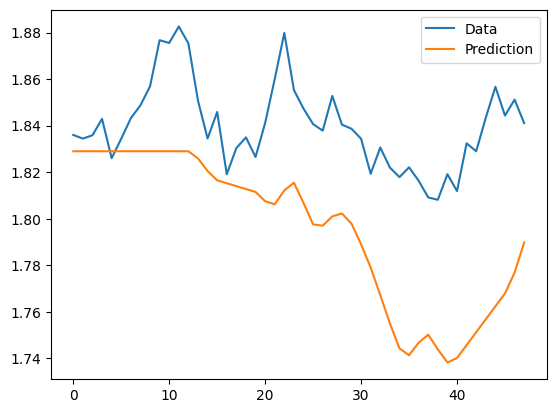

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


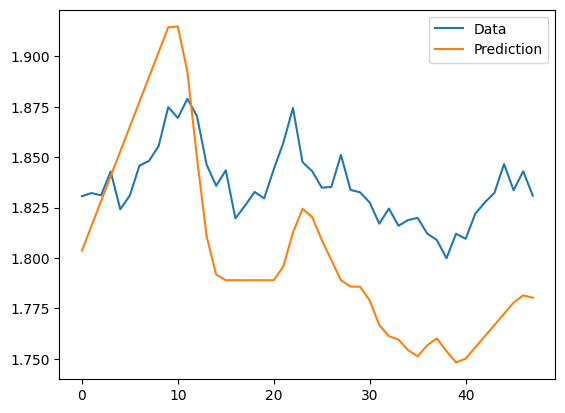

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


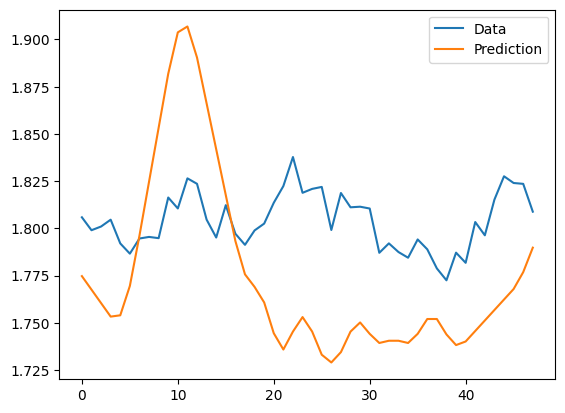

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


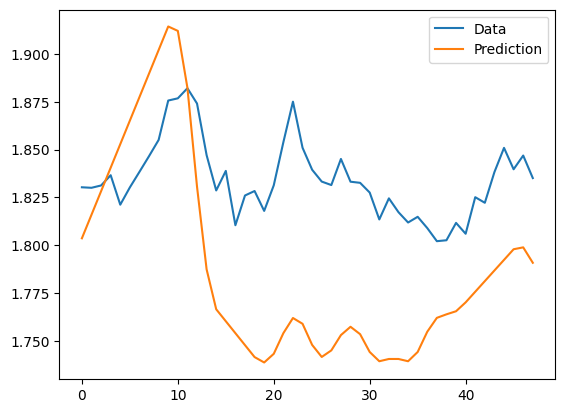

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


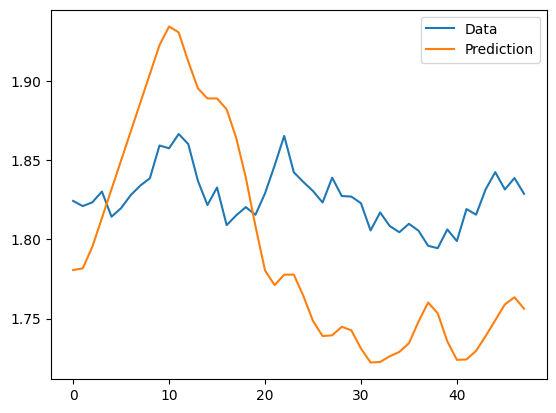

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


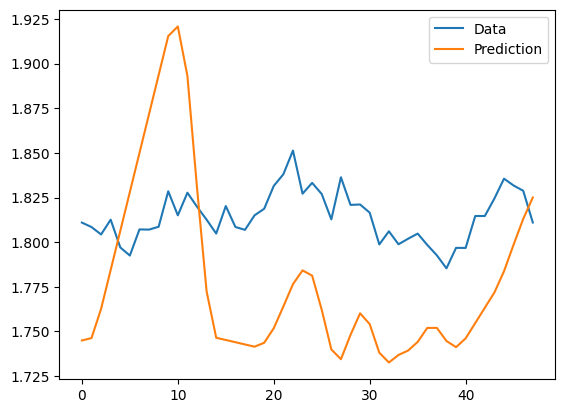

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


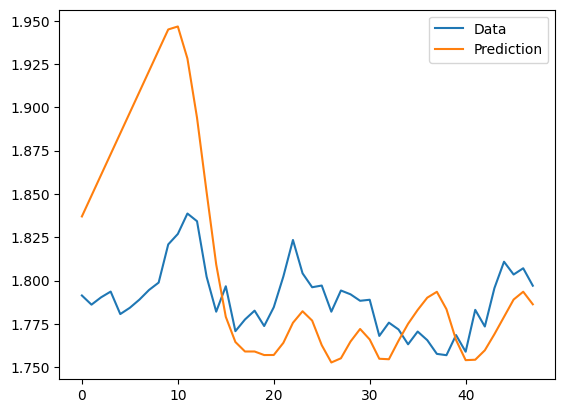

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


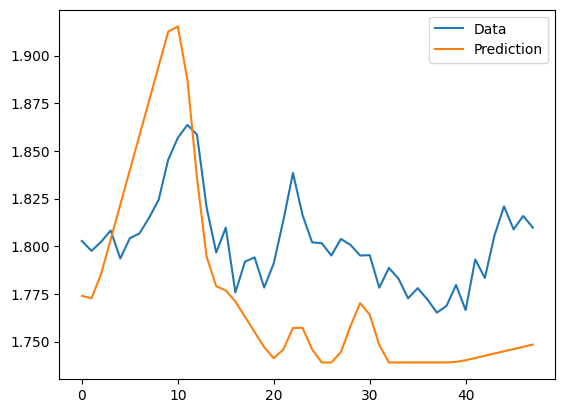

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


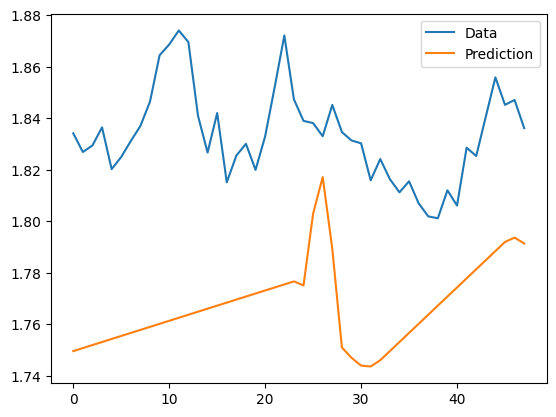

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


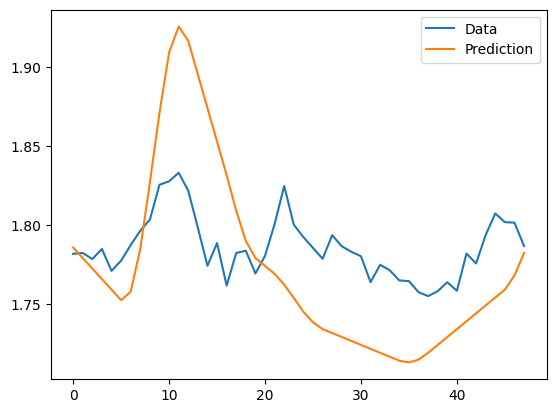

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


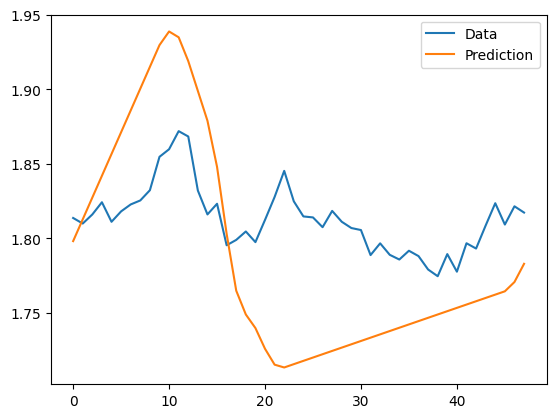

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


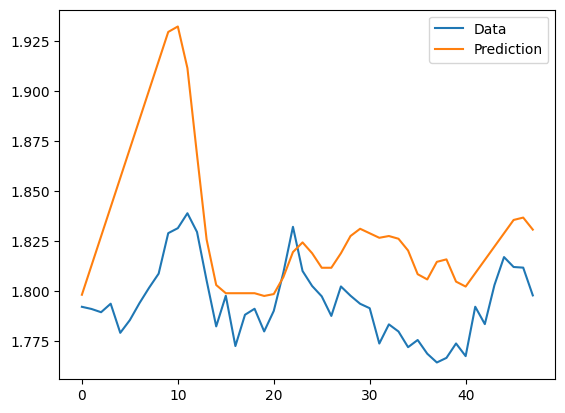

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


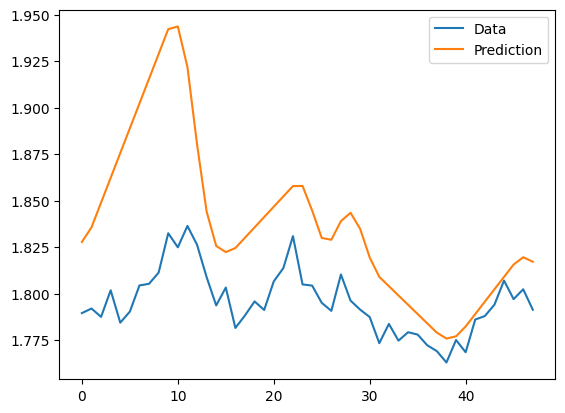

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


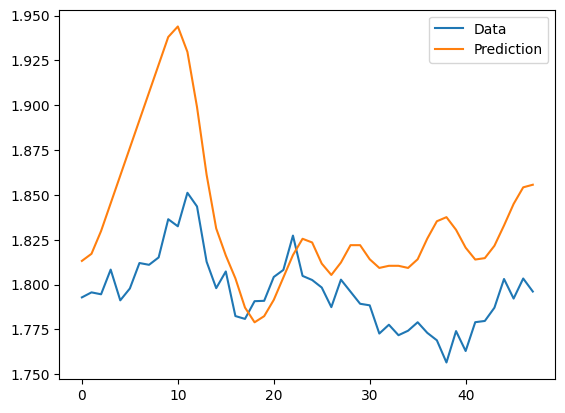

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


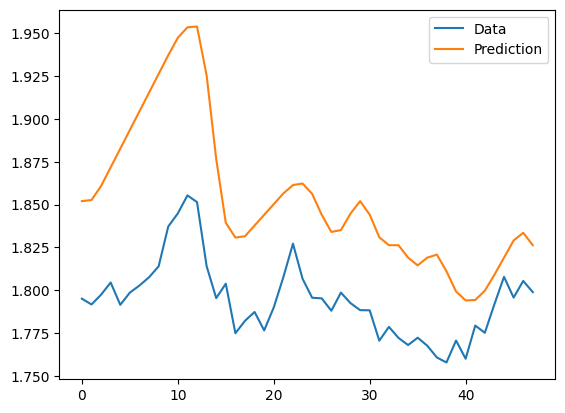

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


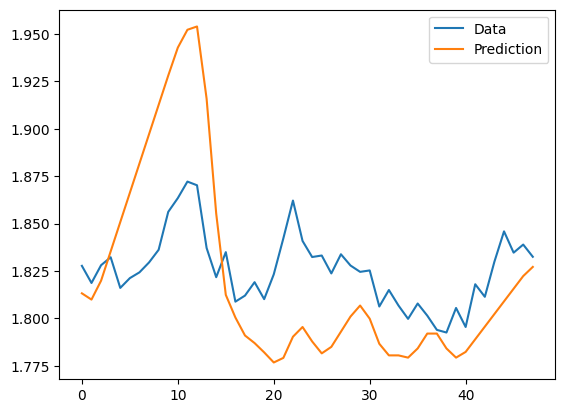

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


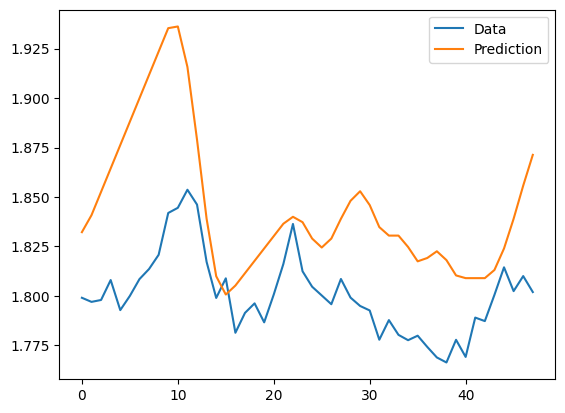

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


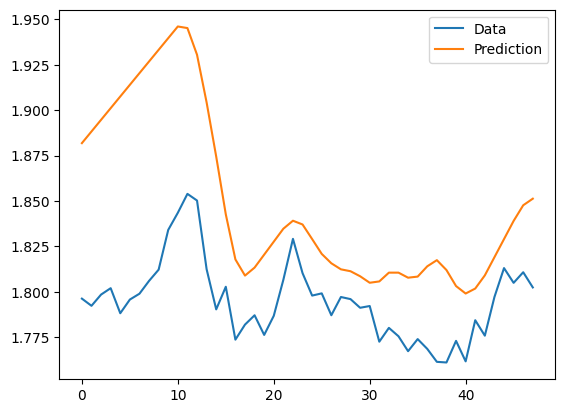

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


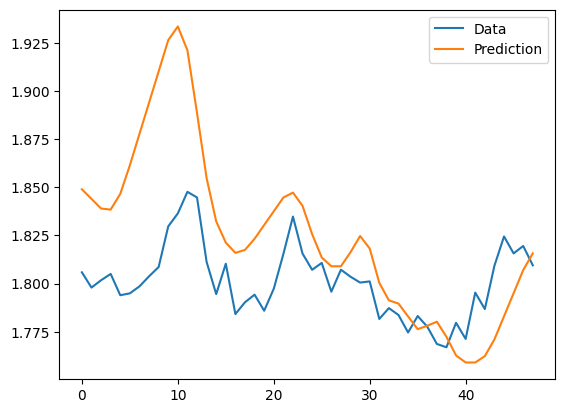

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


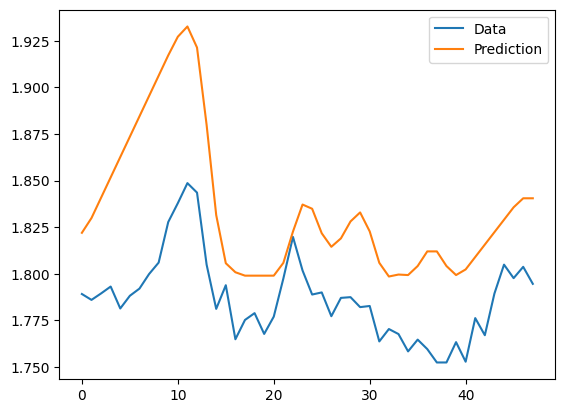

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


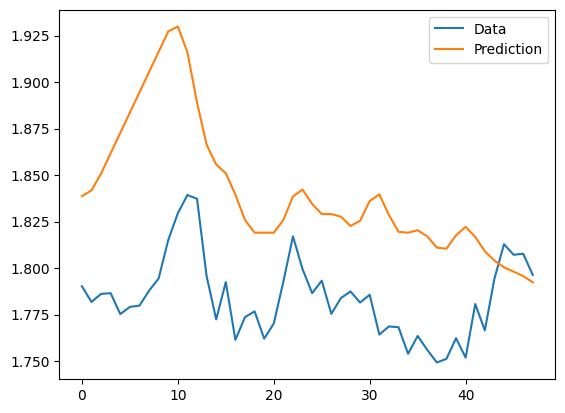

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


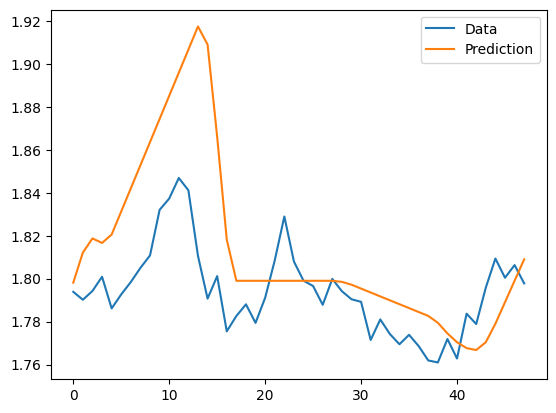

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


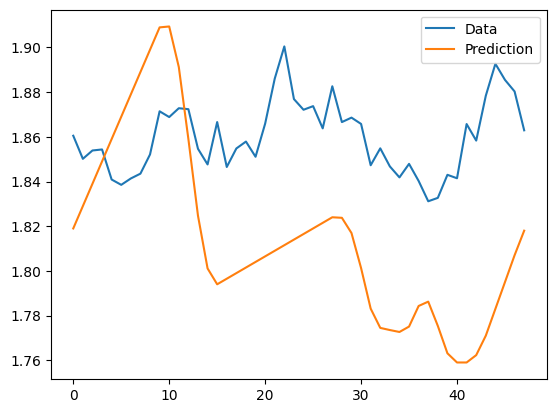

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


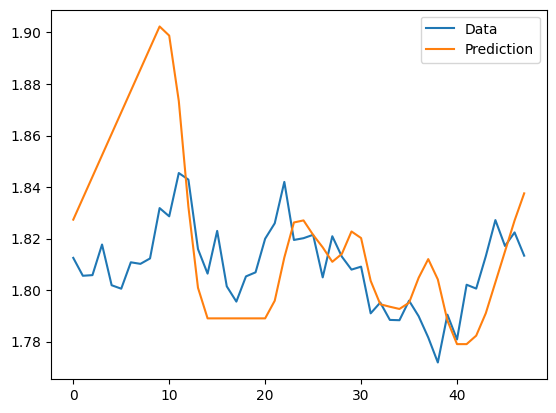

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


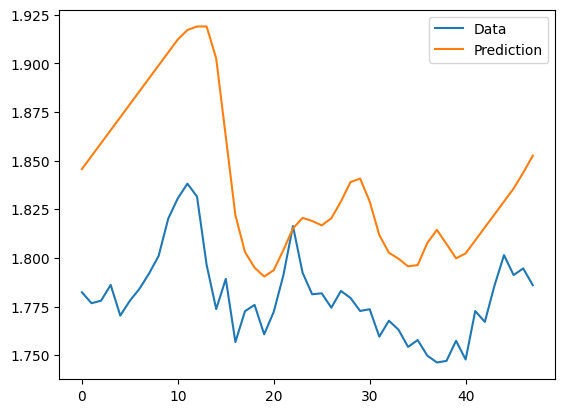

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


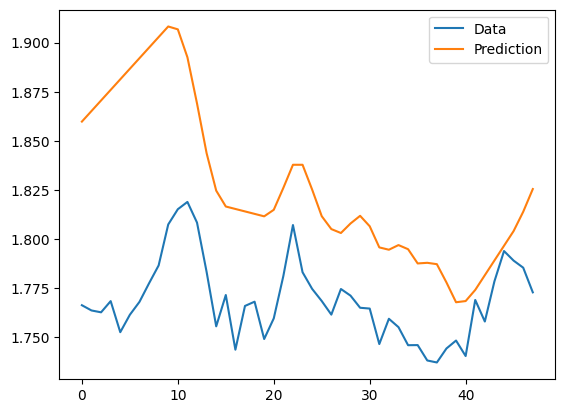

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


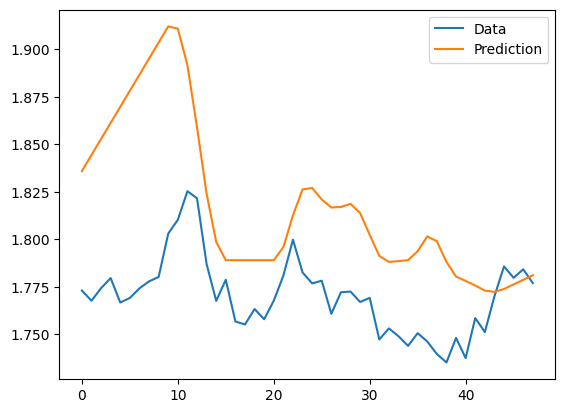

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


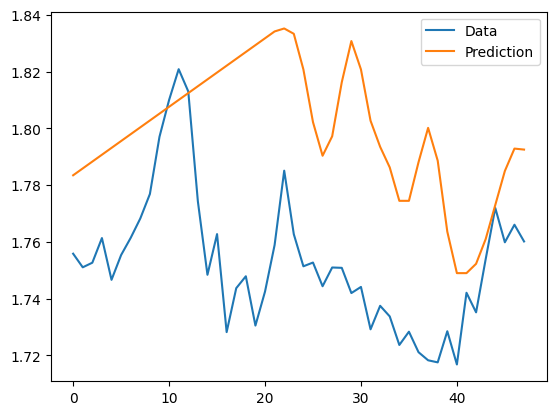

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


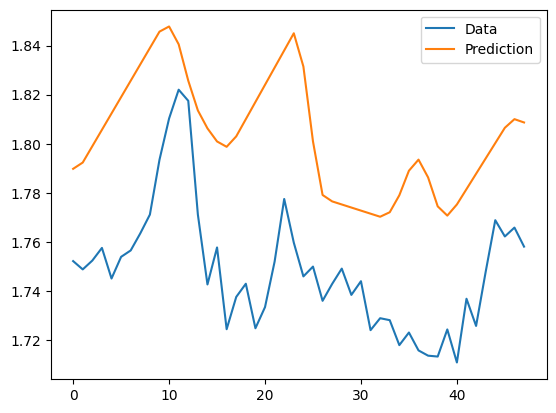

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


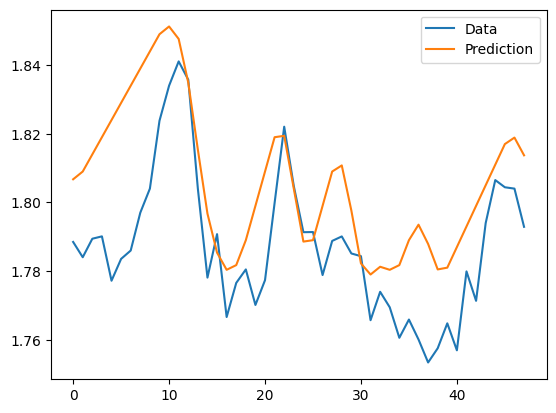

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


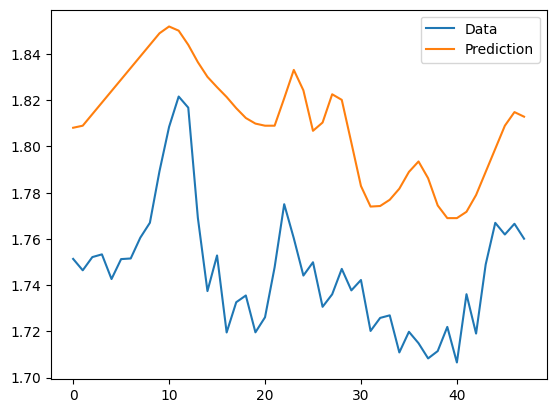

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


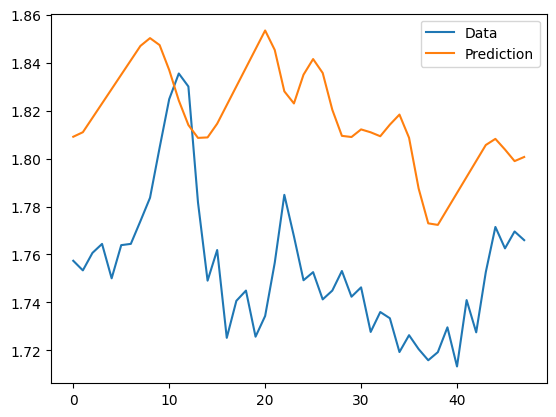

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


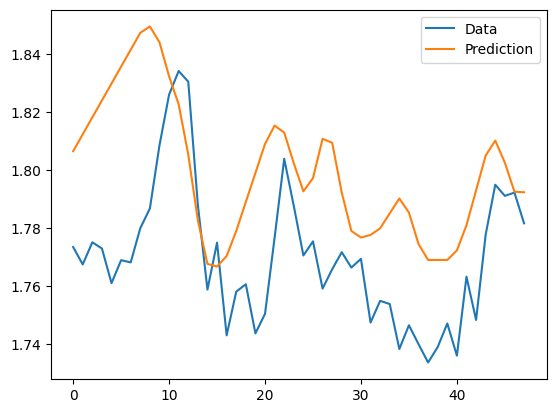

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


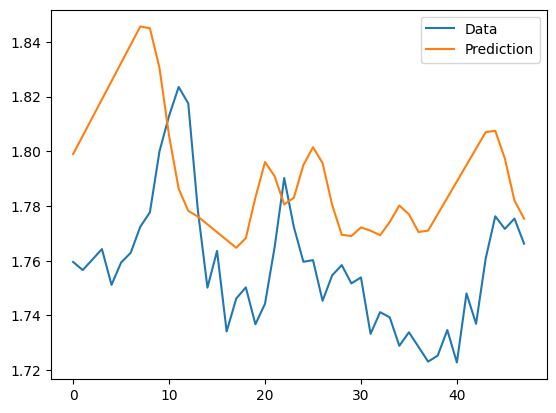

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


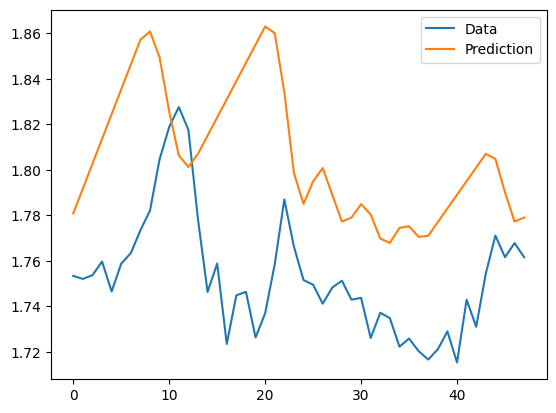

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


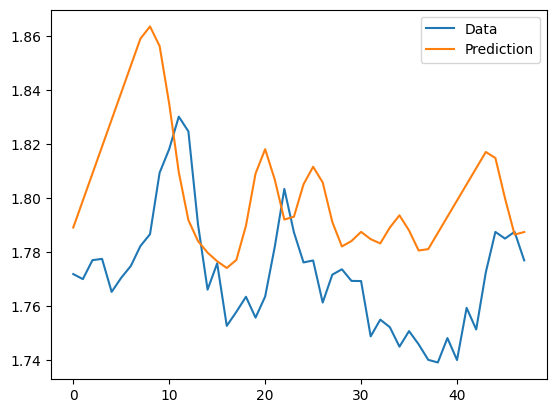

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


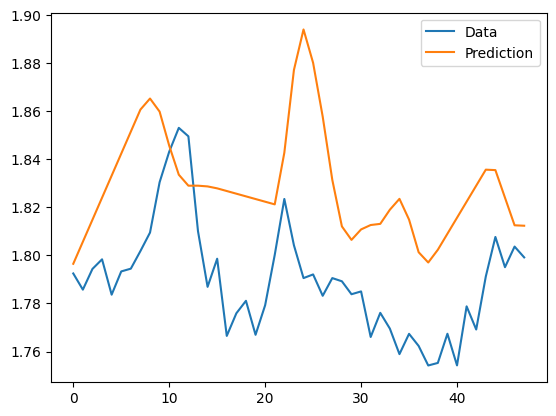

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


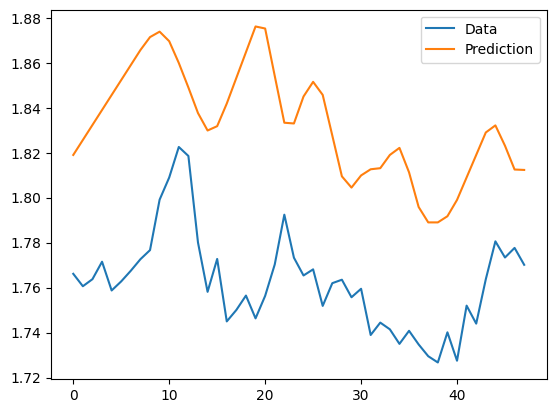

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


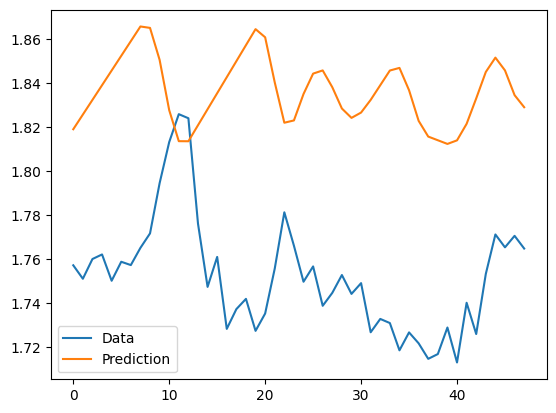

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


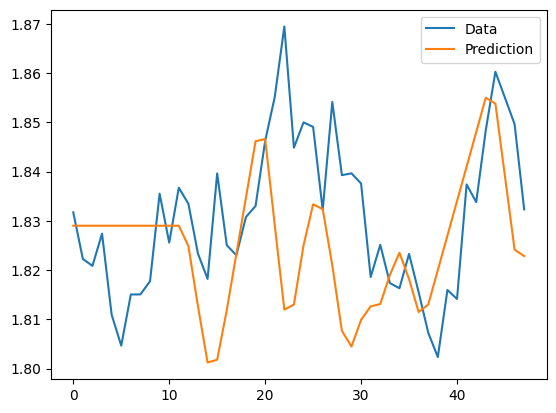

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


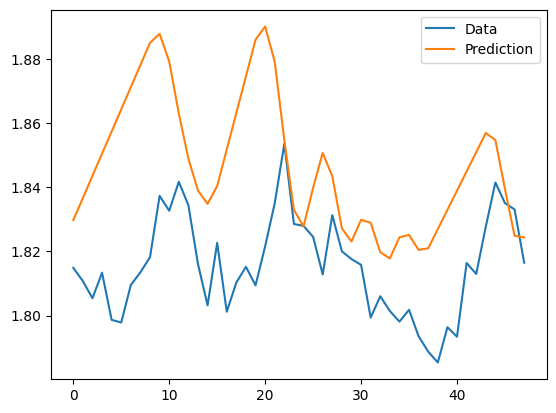

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


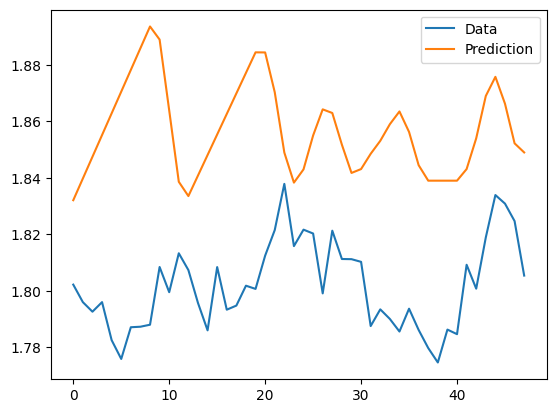

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


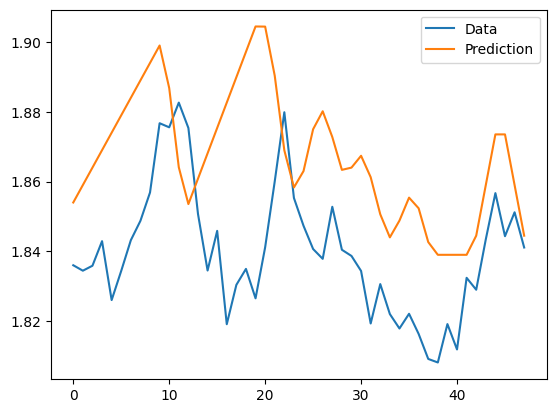

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


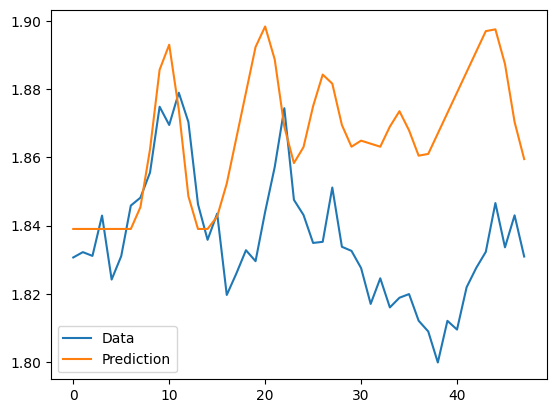

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


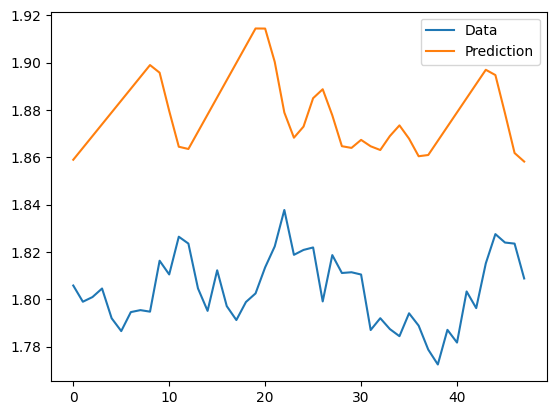

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


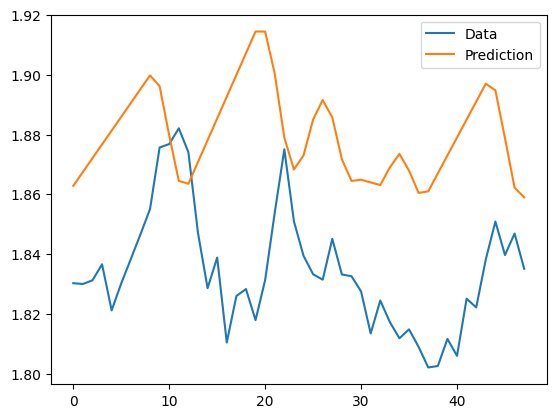

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


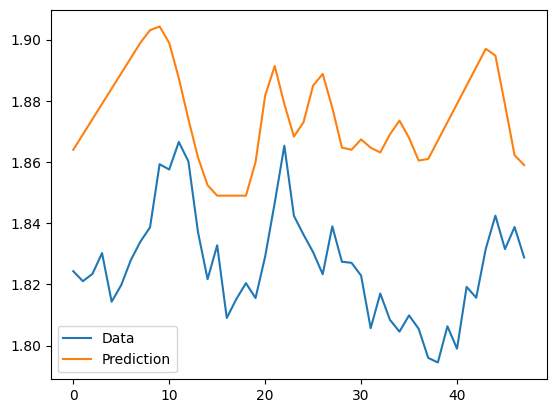

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


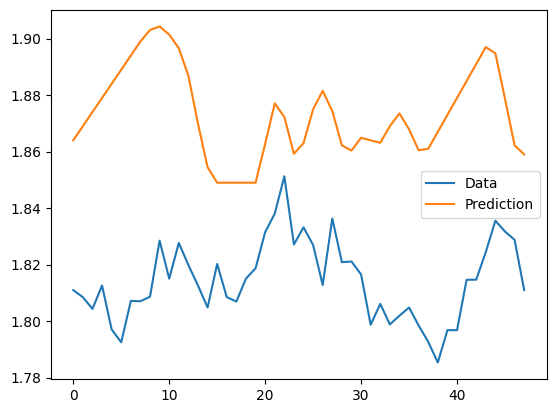

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


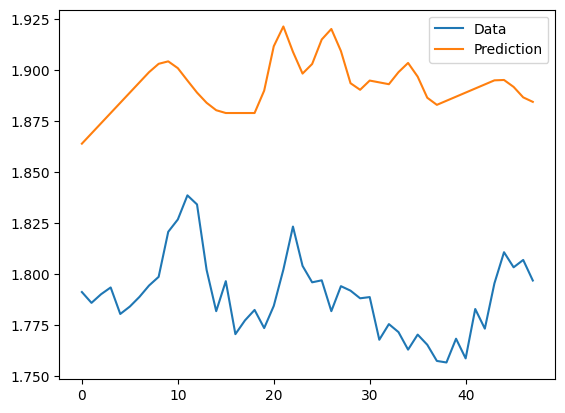

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


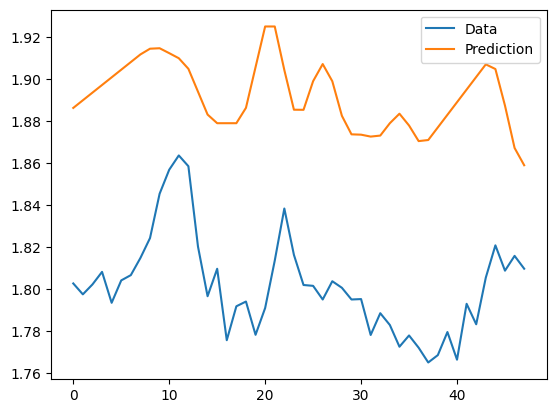

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


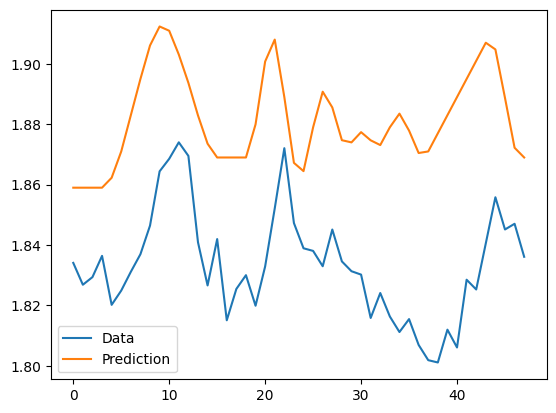

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


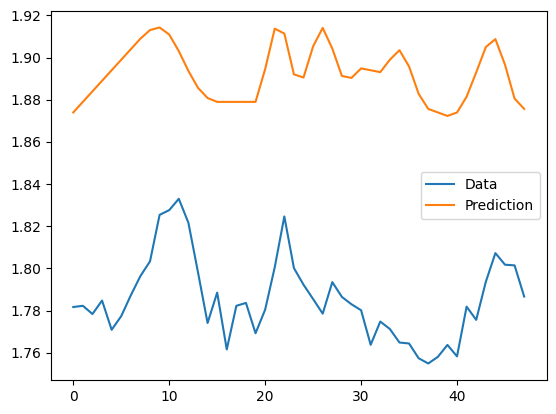

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


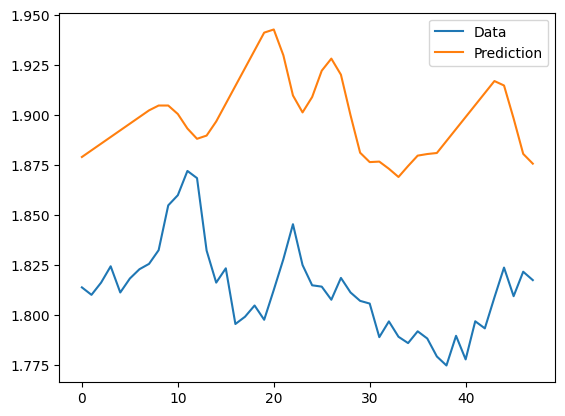

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


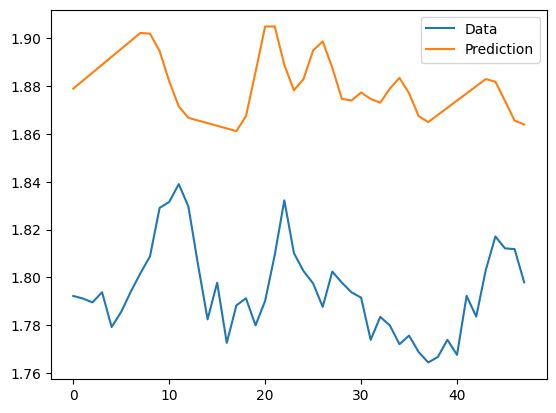

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


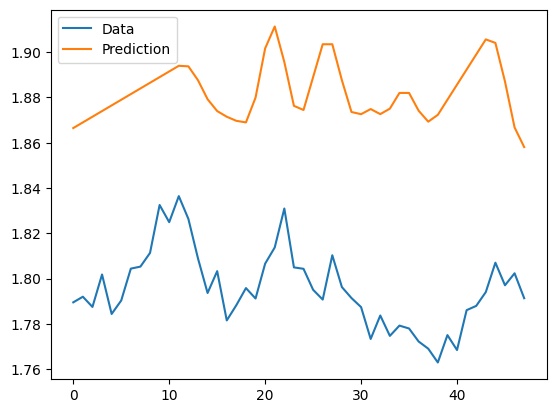

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


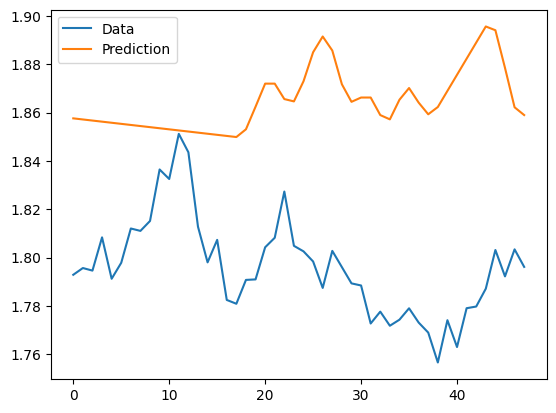

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


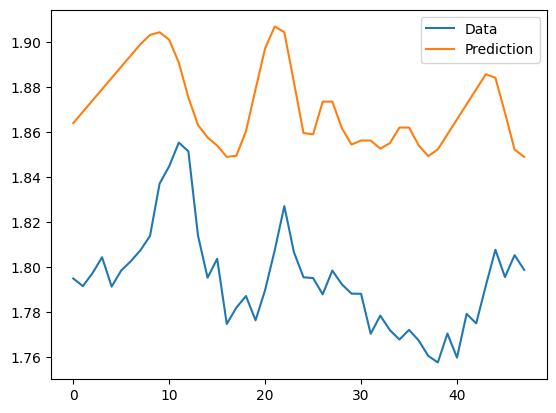

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


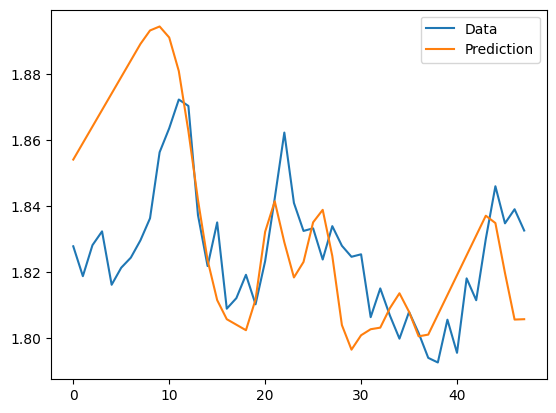

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


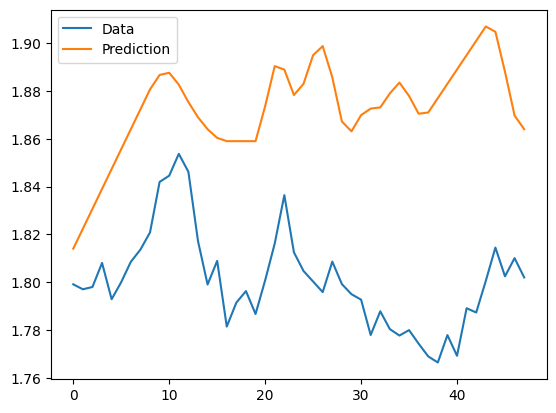

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


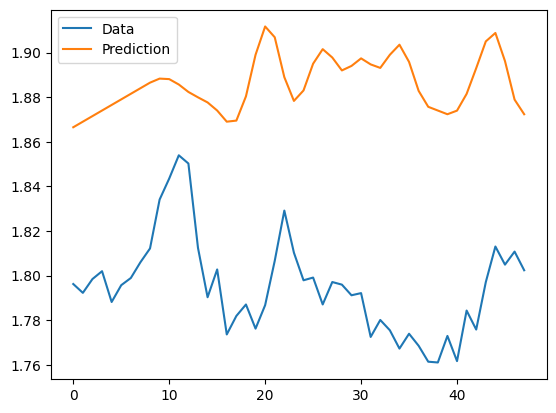

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


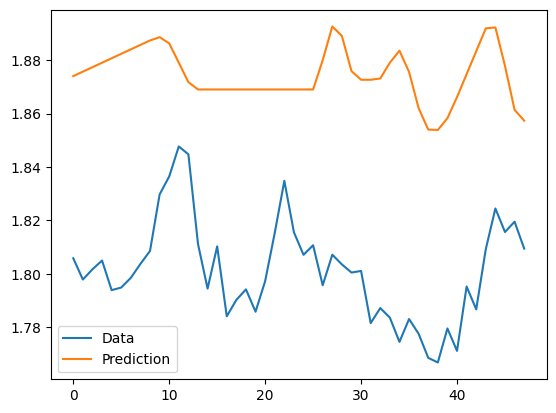

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


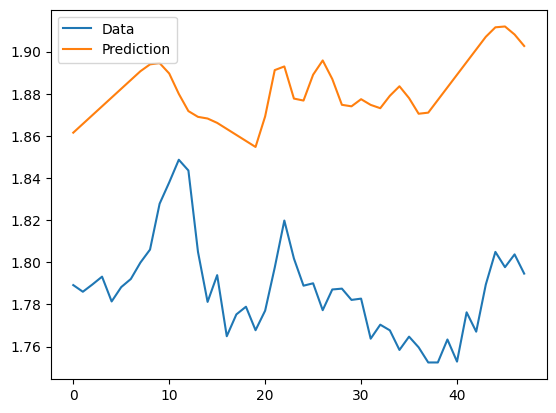

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


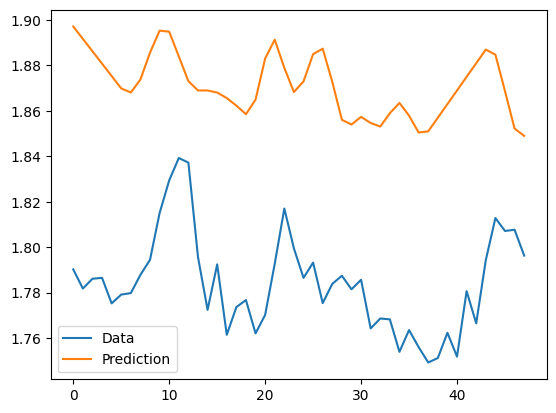

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


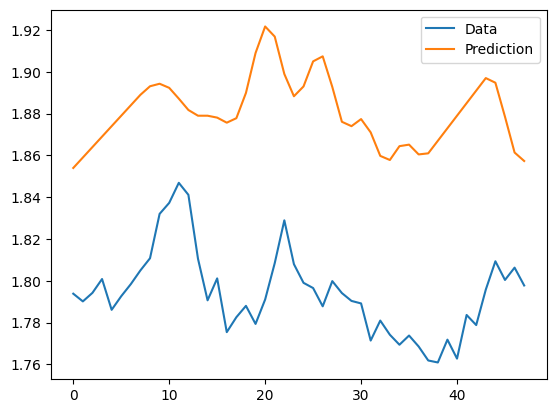

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


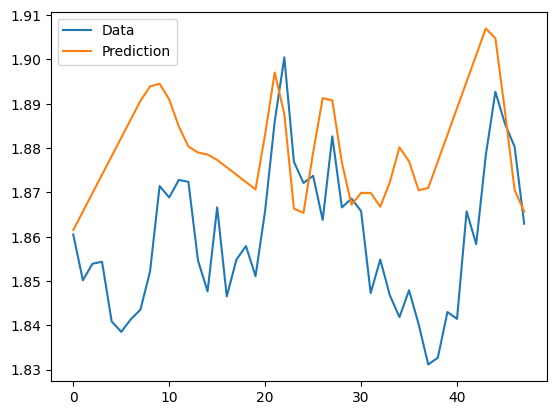

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


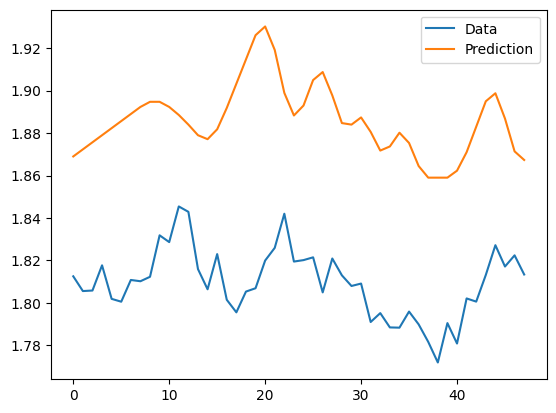

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


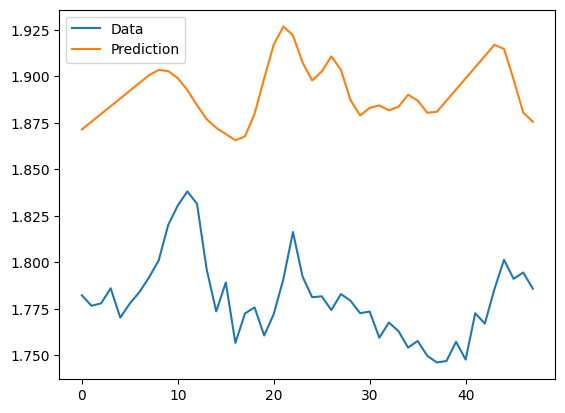

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


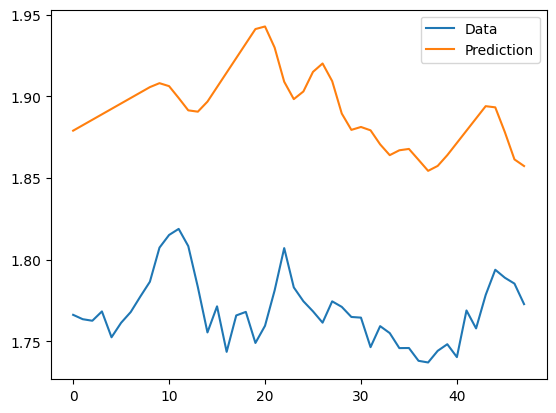

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


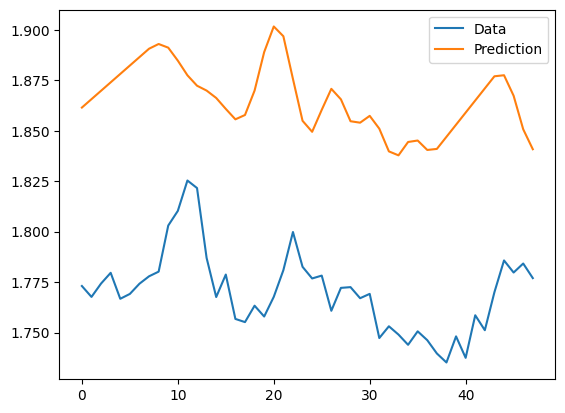

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


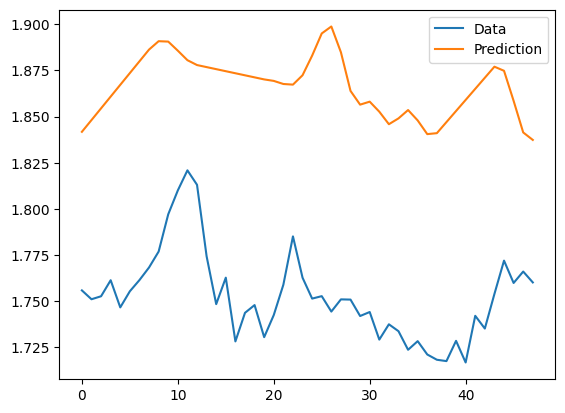

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


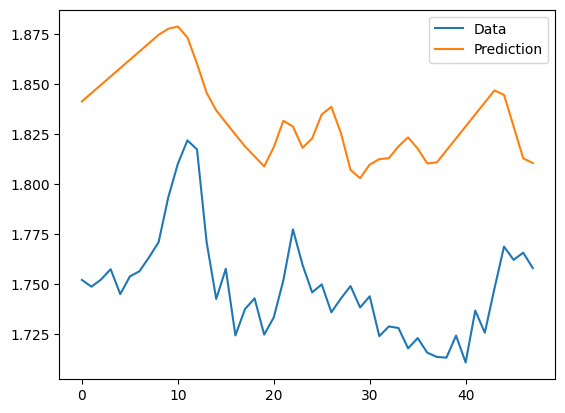

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


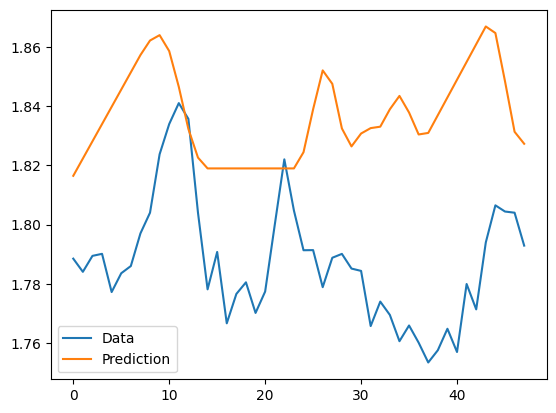

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


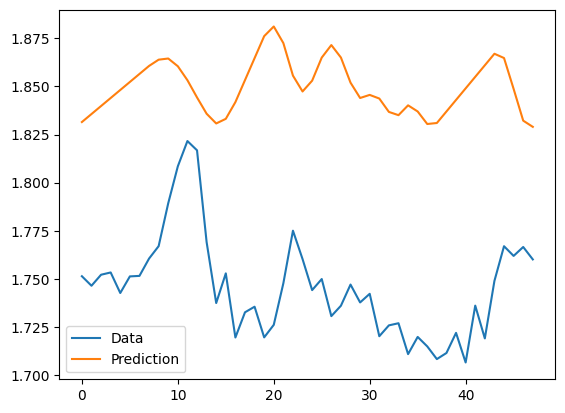

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


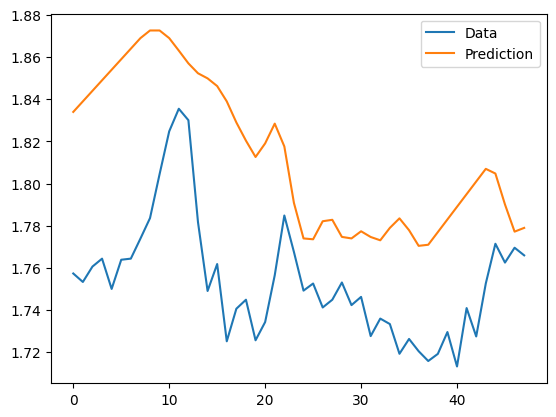

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


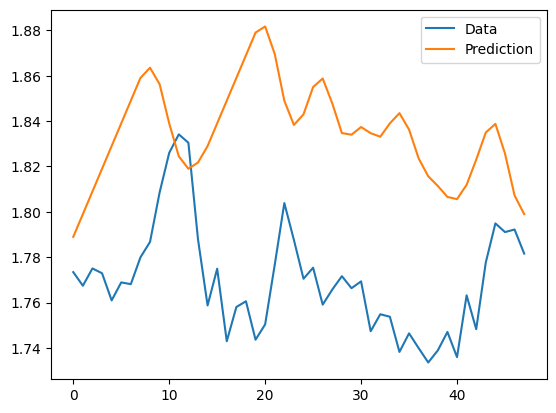

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


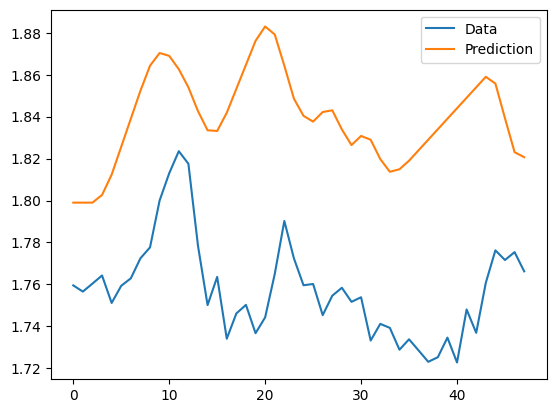

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


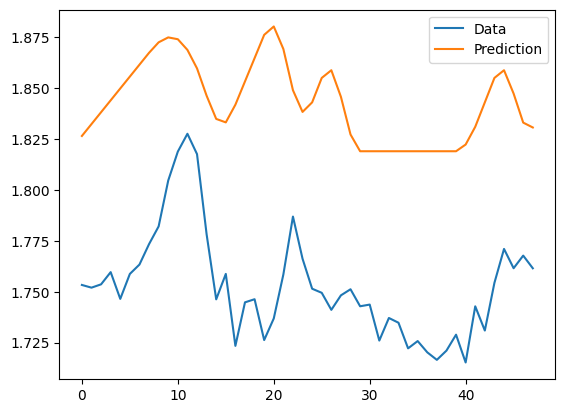

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


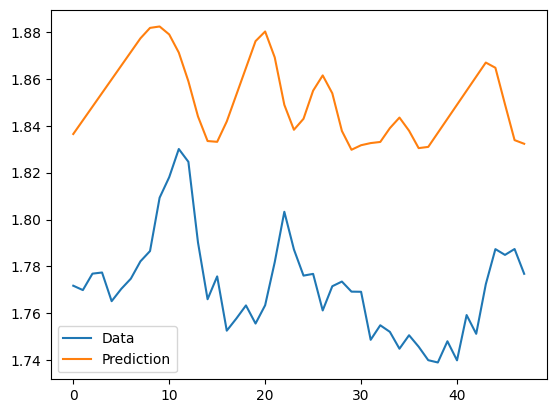

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


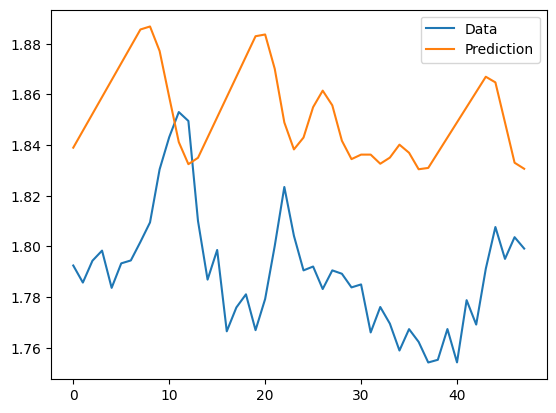

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


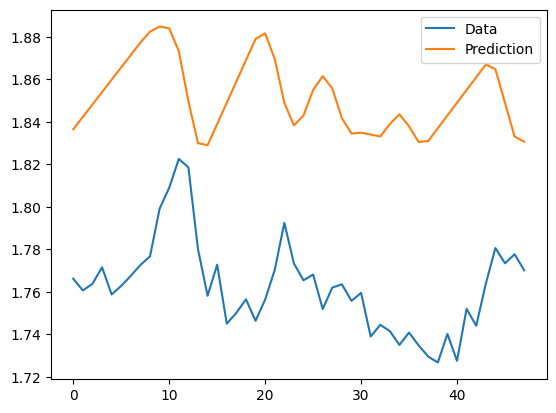

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


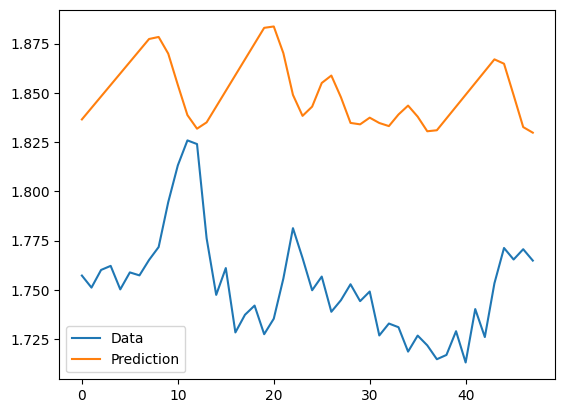

In [228]:
for idx, dataset in enumerate(X_test_splitted):
    prediction = model.predict(dataset.reshape(-1, 48)).reshape(-1)
    y = y_test_splitted[idx]

    plt.plot(prediction, label='Data')
    plt.plot(y_train_splitted[idx], label='Prediction')
    plt.legend()

    plt.show()